In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc1


## Loading

In [63]:
%load_ext autoreload
%autoreload
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from src.modules.data_spliting import split_train_test
from src.modules.data_preprocessing import load_data
import random
from src.modules.data_partition import data_partition
from src.fed_imp.sub_modules.missing_simulate.missing_adder_new import add_missing
from src.fed_imp.sub_modules.client.client_factory import ClientsFactory
from src.fed_imp.sub_modules.strategy.strategy_imp import StrategyImputation
from src.fed_imp.sub_modules.server.load_server import load_server
from src.fed_imp.sub_modules.client.simple_client import SimpleClient
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from dython.nominal import correlation_ratio
import missingno as msno


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
def visualize_ms(clients_ms_datas:list, sort_patterns: bool = False):
    n_cols = 5
    n_clients = len(clients_ms_datas)
    n_rows = (n_clients + 4)//n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3), squeeze=False)
    for i in range(n_clients):
        ax = axes[i//n_cols, i%n_cols]
        d = pd.DataFrame(clients_ms_datas[i])
        d = d.sort_values(by=d.columns[-1])
        if sort_patterns:
            msno.matrix(d, ax=ax, sparkline=False, sort='ascending')
        else:
            msno.matrix(d, ax=ax, sparkline=False)
        ax.set_title('Client {}'.format(i))
    plt.tight_layout()

def correlation(original_data, centralized_data):
    original_df = pd.DataFrame(original_data)
    target_col = original_df.columns[-1]
    correlation_ret = original_df.corrwith(original_df[target_col], method=correlation_ratio).sort_values(ascending=False)
    print(correlation_ret)

    centralized_df = pd.DataFrame(centralized_data)
    target_col = centralized_df.columns[-1]
    correlation_ret = centralized_df.corrwith(original_df[target_col], method=correlation_ratio).sort_values(ascending=False)
    print(correlation_ret)

def run_pred(clf_name, X_train, y_train, X_test, y_test):
    accus = []
    for i in range(5):
        seed = 21 + i*93940
        if clf_name == 'LR':
            clf = LogisticRegression(random_state=seed, max_iter=1000)
        elif clf_name == 'MLP':
            clf = MLPClassifier(
                [32, 32], batch_size = 128, random_state=seed, alpha = 0.001, max_iter = 1000)
        else:
            raise ValueError('clf_name should be LR or MLP')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accus.append(metrics.accuracy_score(y_test, y_pred))
    return np.mean(accus), np.std(accus)

def sklearn_evaluation(rets):

    original_data = rets['data']['origin_data'].reshape(-1, rets['data']['origin_data'].shape[-1])
    centralized_data = rets['data']['imputed_data'].reshape(-1, rets['data']['origin_data'].shape[-1])
    test_data = rets['data']['test_data']

    X_train = centralized_data[:, :-1]
    y_train = centralized_data[:, -1]
    X_test = test_data[:, :-1]
    y_test = test_data[:, -1]
    accu, std = run_pred('MLP', X_train, y_train, X_test, y_test)
    print("Accuracy imputed centralized MLP:{:.4f} ({:.3f})".format(accu, std))

    accu, std = run_pred('LR', X_train, y_train, X_test, y_test)
    print("Accuracy imputed centralized LR:{:.4f} ({:.3f})".format(accu, std))

    X_train = original_data[:, :-1]
    y_train = original_data[:, -1]
    X_test = test_data[:, :-1]
    y_test = test_data[:, -1]
    accu, std = run_pred('MLP', X_train, y_train, X_test, y_test)
    print("Accuracy orignal centralized MLP:{:.4f} ({:.3f})".format(accu, std))

    accu, std = run_pred('LR', X_train, y_train, X_test, y_test)
    print("Accuracy orignal centralized MLP:{:.4f} ({:.3f})".format(accu, std))


In [4]:
experiment_config_template = {
  "num_clients": 20,
  "data": {
    "dataset_name": "ijcnn_balanced_pca",
    "normalize": True
  },
  "data_partition": {
    "strategy": "sample@p=0.01",
    "params": {}
  },
  "missing_simulate": {
    "mr_strategy": "fixed",
    "mf_strategy": "all",
    "mm_strategy": "mary_lr"
  },
  "imputation": {
    "initial_strategy_num": "mean",
    "initial_strategy_cat": "mode",
    "estimator_num": "ridge_cv",
    "estimator_cat": "logistic_cv",
    "imp_evaluation_model": "logistic",
    "imp_evaluation_params": {
      "tune_params": "gridsearch"
    },
    "clip": False
  },
  "agg_strategy_imp": {
    "strategy": "fedavg-s",
    "params": {
      "ms_field": "missing_cell_pct",
      "beta": 0.7
    }
  },
  "server_type": "fedavg_pytorch",
  "server": {
    "impute_mode": "instant",
    "imp_round": 40,
    "imp_local_epochs": 0,
    "pred_round": 0,
    "pred_local_epochs": 0,
    "model_fit_mode": "one_shot"
  },
  "pred_model": {
    "model_params": {
      "model": "2nn",
      "num_hiddens": 128,
      "model_init_config": None,
      "model_other_params": None
    },
    "train_params": {
      "batch_size": 128,
      "learning_rate": 0.001,
      "weight_decay": 0.0001,
      "pred_round": 200,
      "pred_local_epochs": 3
    }
  },
  "experiment": {
    "n_rounds": 1,
    "seed": 102931466,
    "mtp": False,
    "random_seed": 50,
    "num_process": 3,
    "test_size": 0.1,
    "track": True
  },
  "tune_params": False,
  "track": False,
  "tune_params": True,
  "prediction": False,
  "save_state": False,
  "test_size": 0.1,
  "algo_params": {
    "local": {},
    "fedavg-s": {},
    "fedwavg": {
      "alpha": 0.9
    },
    "fedmechw": {
      "client_thres": 1.0,
      "alpha": 0.8,
      "beta": 0.15
    },
    "fedmechclw": {
      "client_thres": 0.2,
      "thres1": 0.2,
      "alpha": 0.5
    },
    'testavg':{
        
    },
    "scale_factor": 4
  }
}

## Simulation

## MARY - Naive Avgerage

### simulate missing

In [11]:
config = experiment_config_template.copy()
config['data']['dataset_name'] = 'ijcnn_balanced_pca'
config['num_clients'] = 20
config['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config['missing_simulate']['mf_strategy'] = 'all'
config['missing_simulate']['mm_strategy'] = 'mary_lr@sp=extreme'
config['data_partition']['strategy'] = 'sample@p=0.01'

In [12]:
configuration = config
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)

sample {'p': '0.01'}
['mary_left' 'mary_left' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right']


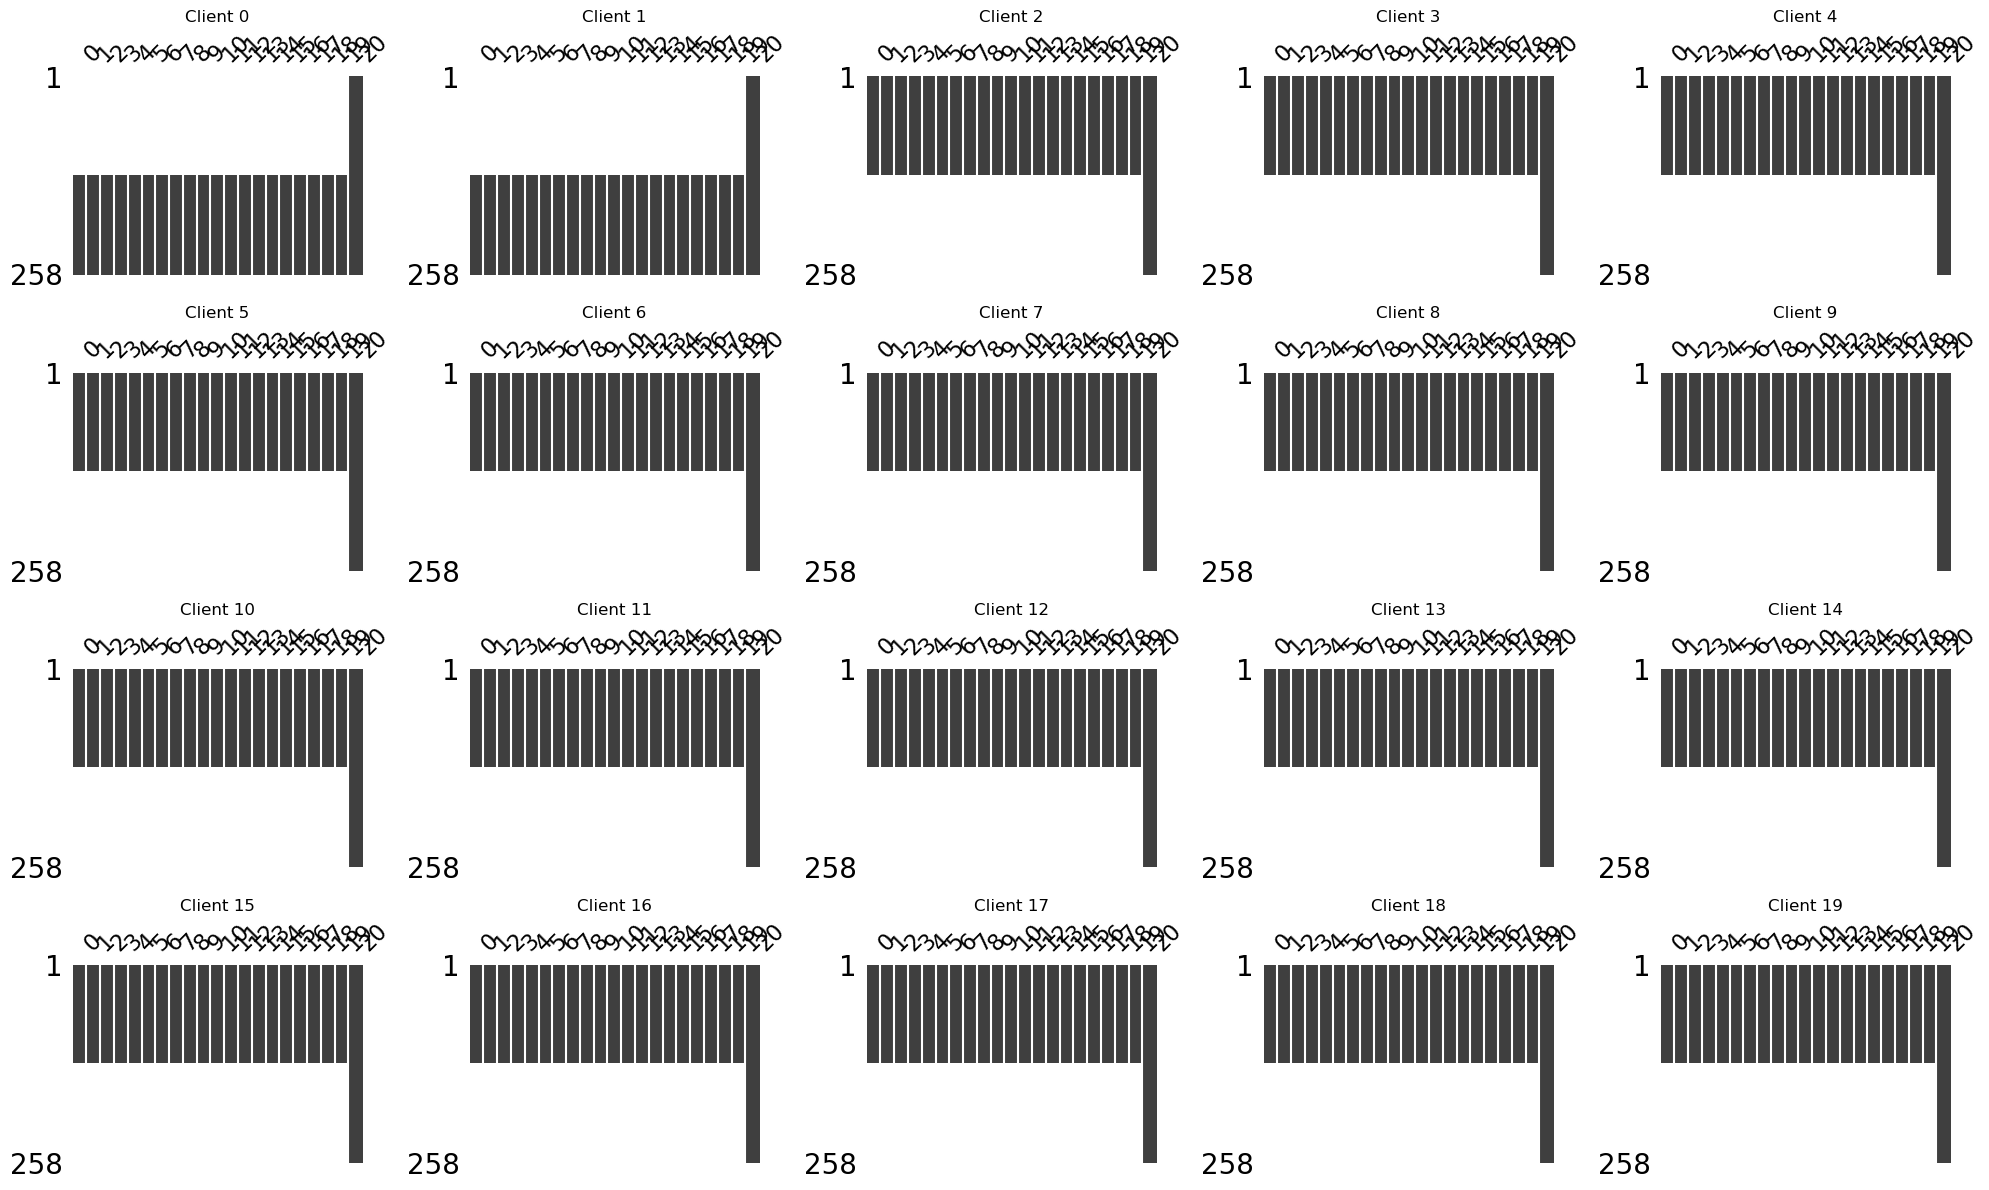

In [13]:
visualize_ms(data_ms_clients)

### Federated Imputation

In [14]:
configuration['agg_strategy_imp']['strategy'] = 'fedavg-s'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret = server.run()

2023-07-18 23:56:21.655 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 185.03182069998002


In [16]:
ret['data']['origin_data'].shape

(20, 258, 21)

In [17]:
original_data = ret['data']['origin_data'].reshape(-1, 21)
print(original_data.shape)
centralized_data = ret['data']['imputed_data'].reshape(-1, 21)
print(centralized_data.shape)
test_data = ret['data']['test_data']
print(test_data.shape)
print(ret['imp_result'])

(5160, 21)
(5160, 21)
(11051, 21)
{'imp@rmse': 0.19759293126125002, 'imp@ws': 1.4324463889953511, 'imp@sliced_ws': 0.09483412125857539}


### Centralized

In [18]:
correlation(original_data, centralized_data)

20    1.000000
18    0.465797
16    0.370190
15    0.352651
14    0.212140
11    0.111021
12    0.092539
4     0.082417
13    0.072464
2     0.055230
1     0.040237
19    0.037266
17    0.025934
3     0.019406
6     0.012952
0     0.010435
8     0.009498
10    0.008451
5     0.003681
9     0.002828
7     0.002159
dtype: float64
20    1.000000
18    0.142221
15    0.109583
16    0.095929
14    0.054051
10    0.050278
0     0.035197
12    0.025021
1     0.023981
4     0.022670
11    0.021891
8     0.017048
6     0.016355
13    0.015193
3     0.011593
19    0.010664
9     0.008719
17    0.005451
7     0.004136
5     0.002004
2     0.001487
dtype: float64


In [25]:
sklearn_evaluation(ret)

Accuracy imputed centralized MLP:0.7775 (0.042)
Accuracy imputed centralized LR:0.7499 (0.000)
Accuracy orignal centralized MLP:0.9375 (0.002)
Accuracy orignal centralized MLP:0.8711 (0.000)


### Evaluation FedAvg Our Implementation

In [27]:
server_config_tmpl = {
    "server_name": 'fedavg_mlp_pytorch_pred',
    "server_pred_config": {
        "model_params": {
            "model": "2nn",
            "num_hiddens": 32,
            "model_init_config": None,
            "model_other_params": None
        },
        "train_params": {
            "batch_size": 128,
            "learning_rate": 0.001,
            "weight_decay": 0.001,
            "pred_round": 1000,
            "pred_local_epochs": 5,
            'local_epoch': 5,
            'sample_pct': 1
        }
    },
    "server_config": {
        'pred_rounds': 1,
        'seed': 21
    }
}

In [28]:
clients = {}
data_imp = ret['data']['imputed_data']
missing_mask = ret['data']['missing_mask']
data_true = ret['data']['origin_data']
n_clients = ret['data']['origin_data'].shape[0]
for client_id in range(n_clients):
    clients[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp[client_id],
        missing_mask=missing_mask[client_id],
        data_true=data_true[client_id],
        data_test=test_data
    )

pred_config = server_config_tmpl.copy()
server_name = 'fedavg_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_config = pred_config['server_config']
server = load_server(
        server_name, clients=clients, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data
    )

pred_ret = server.prediction()

2023-07-19 00:08:20.332 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.5000, test_f1: 0.3336, val_loss: 0.3353, val_accu: 0.8990, val_f1: 0.8990


KeyboardInterrupt: 

In [138]:
clients = {}
data_imp = ret['data']['imputed_data']
missing_mask = ret['data']['missing_mask']
data_true = ret['data']['origin_data']
n_clients = ret['data']['origin_data'].shape[0]
for client_id in range(n_clients):
    clients[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp[client_id],
        missing_mask=missing_mask[client_id],
        data_true=data_true[client_id],
        data_test=test_data
    )

pred_config = server_config_tmpl.copy()
server_name = 'central_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_pred_config['train_params']['pred_round'] = 1000
server_config = pred_config['server_config']
server = load_server(
        server_name, clients=clients, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data
    )

pred_ret = server.prediction()

2023-07-18 21:03:33.408 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.4976, train_loss: 0.6875 val_accu: 0.8365 val_f1: 0.8352
2023-07-18 21:03:34.468 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 10, test_accu: 0.5000, train_loss: 0.3198 val_accu: 0.9000 val_f1: 0.9000
2023-07-18 21:03:35.530 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 20, test_accu: 0.5007, train_loss: 0.3103 val_accu: 0.9000 val_f1: 0.9000
2023-07-18 21:03:36.540 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 30, test_accu: 0.5103, train_loss: 0.3007 val_accu: 0.9000 val_f1: 0.9000
2023-07-18 21:03:37.751 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 40, test_accu: 0.5214, train_loss: 0.2872 val_accu: 0.9010 val_f1: 0.9010
2023-07-18 21:03:38.828 | INFO 

In [119]:
pred_ret

{'accu_mean': 0.8775676409374717,
 'f1_mean': 0.8765730830465115,
 'accu_std': 0.0,
 'f1_std': 0.0}

## MARY - Use complementary Models

In [30]:
config = experiment_config_template.copy()
config['data']['dataset_name'] = 'ijcnn_balanced_pca'
config['num_clients'] = 20
config['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config['missing_simulate']['mf_strategy'] = 'all'
config['missing_simulate']['mm_strategy'] = 'mary_lr@sp=extreme'
config['data_partition']['strategy'] = 'sample@p=0.01'

configuration = config
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)

sample {'p': '0.01'}
['mary_left' 'mary_left' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right']


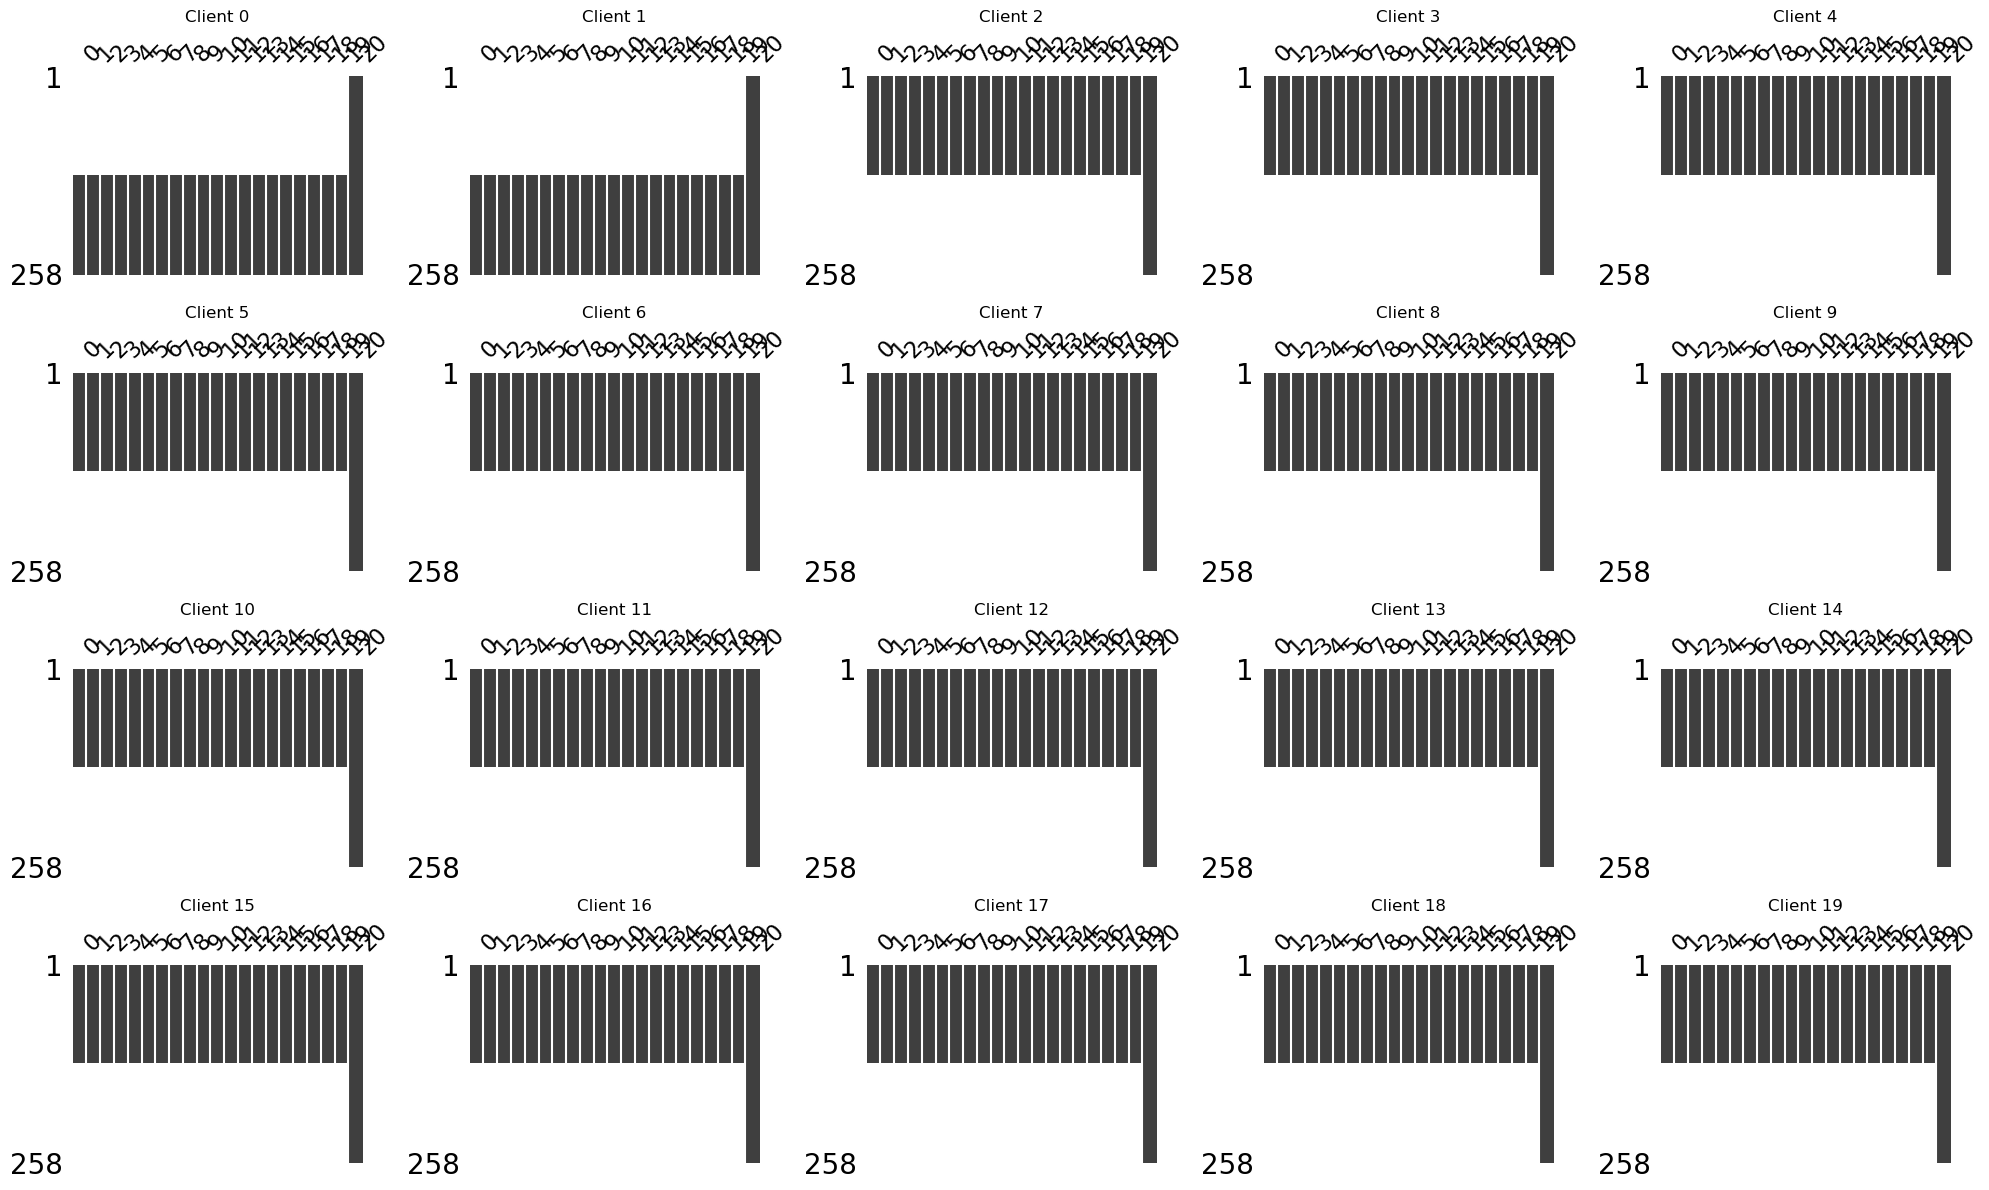

In [31]:
visualize_ms(data_ms_clients)

In [32]:
configuration['agg_strategy_imp']['strategy'] = 'testavg'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret3 = server.run()

testavg


2023-07-19 00:12:28.917 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 191.34085959999356


In [34]:
original_data3 = ret3['data']['origin_data'].reshape(-1, ret3['data']['origin_data'].shape[-1])
print(original_data.shape)
centralized_data3 = ret3['data']['imputed_data'].reshape(-1, ret3['data']['imputed_data'].shape[-1])
print(centralized_data.shape)
test_data3 = ret3['data']['test_data']
print(test_data.shape)
ret3['imp_result']

(5160, 21)
(5160, 21)
(11051, 21)


{'imp@rmse': 0.19693300243916945,
 'imp@ws': 1.4185738397245446,
 'imp@sliced_ws': 0.09436126048069077}

In [35]:
correlation(original_data3, centralized_data3)

20    1.000000
18    0.465797
16    0.370190
15    0.352651
14    0.212140
11    0.111021
12    0.092539
4     0.082417
13    0.072464
2     0.055230
1     0.040237
19    0.037266
17    0.025934
3     0.019406
6     0.012952
0     0.010435
8     0.009498
10    0.008451
5     0.003681
9     0.002828
7     0.002159
dtype: float64
20    1.000000
18    0.603299
15    0.501730
16    0.475718
14    0.289049
1     0.148011
12    0.141023
11    0.135273
4     0.119374
13    0.110954
8     0.090190
6     0.074563
19    0.059062
3     0.048058
10    0.038597
9     0.034681
5     0.028758
7     0.024534
17    0.019758
0     0.013647
2     0.005270
dtype: float64


In [36]:
sklearn_evaluation(ret3)

Accuracy imputed centralized MLP:0.7517 (0.073)
Accuracy imputed centralized LR:0.8044 (0.000)
Accuracy orignal centralized MLP:0.9335 (0.003)
Accuracy orignal centralized MLP:0.8711 (0.000)


In [37]:
clients = {}
data_imp = ret3['data']['imputed_data']
missing_mask = ret3['data']['missing_mask']
data_true = ret3['data']['origin_data']
n_clients = ret3['data']['origin_data'].shape[0]
for client_id in range(n_clients):
    clients[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp[client_id],
        missing_mask=missing_mask[client_id],
        data_true=data_true[client_id],
        data_test=test_data3
    )

pred_config = server_config_tmpl.copy()
server_name = 'fedavg_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_config = pred_config['server_config']
server = load_server(
        server_name, clients=clients, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data3
    )

pred_ret = server.prediction()

2023-07-19 00:15:11.932 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.5069, test_f1: 0.3489, val_loss: 0.2034, val_accu: 0.9000, val_f1: 0.9000
2023-07-19 00:15:52.025 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.5108, test_f1: 0.3573, val_loss: 0.2473, val_accu: 0.9000, val_f1: 0.9000
2023-07-19 00:16:30.907 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.5066, test_f1: 0.3477, val_loss: 0.2842, val_accu: 0.9000, val_f1: 0.9000


KeyboardInterrupt: 

In [215]:
clients = {}
data_imp = ret3['data']['imputed_data']
missing_mask = ret3['data']['missing_mask']
data_true = ret3['data']['origin_data']
n_clients = ret3['data']['origin_data'].shape[0]
for client_id in range(n_clients):
    clients[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp[client_id],
        missing_mask=missing_mask[client_id],
        data_true=data_true[client_id],
        data_test=test_data3
    )

pred_config = server_config_tmpl.copy()
server_name = 'central_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_config = pred_config['server_config']
server = load_server(
        server_name, clients=clients, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data3
    )

pred_ret = server.prediction()

2023-07-18 22:32:06.901 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5055, train_loss: 0.6870 val_accu: 0.8135 val_f1: 0.8109
2023-07-18 22:32:08.088 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 10, test_accu: 0.5091, train_loss: 0.2487 val_accu: 0.9000 val_f1: 0.9000
2023-07-18 22:32:09.301 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 20, test_accu: 0.5376, train_loss: 0.1689 val_accu: 0.9519 val_f1: 0.9518
2023-07-18 22:32:10.436 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 30, test_accu: 0.6110, train_loss: 0.1292 val_accu: 0.9635 val_f1: 0.9634
2023-07-18 22:32:11.768 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 40, test_accu: 0.6422, train_loss: 0.1079 val_accu: 0.9673 val_f1: 0.9673
2023-07-18 22:32:12.968 | INFO 

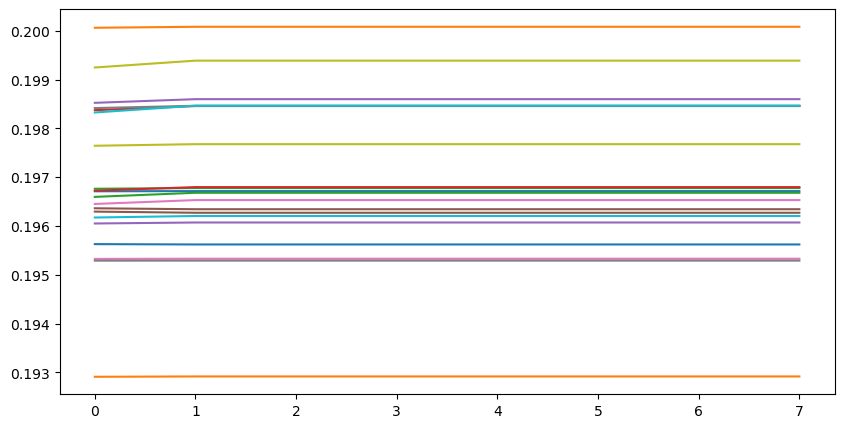

In [38]:
x = list(range(len(ret3['client_imp_history'])))
client_ids = list(ret3['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret3['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

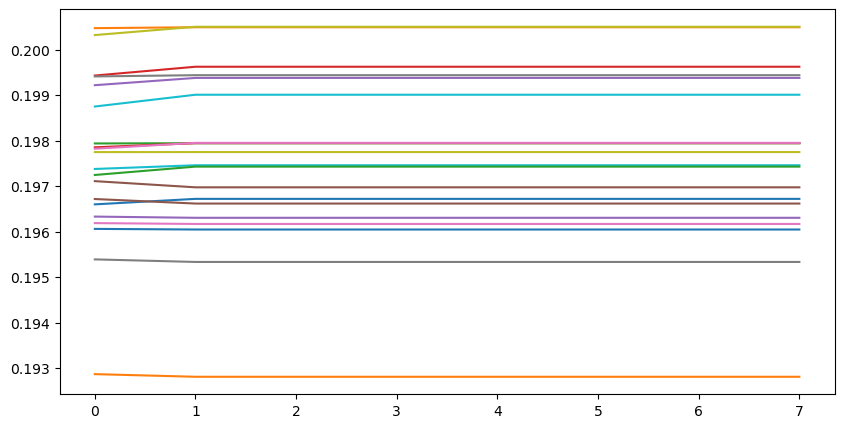

In [39]:
x = list(range(len(ret['client_imp_history'])))
client_ids = list(ret['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

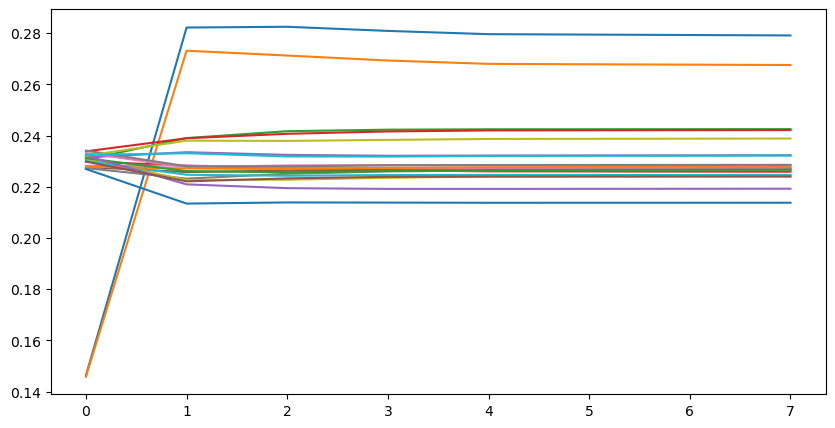

In [50]:
x = list(range(len(ret2['client_imp_history'])))
client_ids = list(ret2['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret2['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

## MNAR

### Simulate Missing

In [65]:
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 20
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme'
config2['data_partition']['strategy'] = 'sample@p=0.01'
config2['agg_strategy_imp']['strategy'] = 'fedavg-s'

In [66]:
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 20
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme'
config2['data_partition']['strategy'] = 'sample@p=0.01'
config2['agg_strategy_imp']['strategy'] = 'fedavg-s'

configuration = config2
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients2 = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients2, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)

sample {'p': '0.01'}
['mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right']


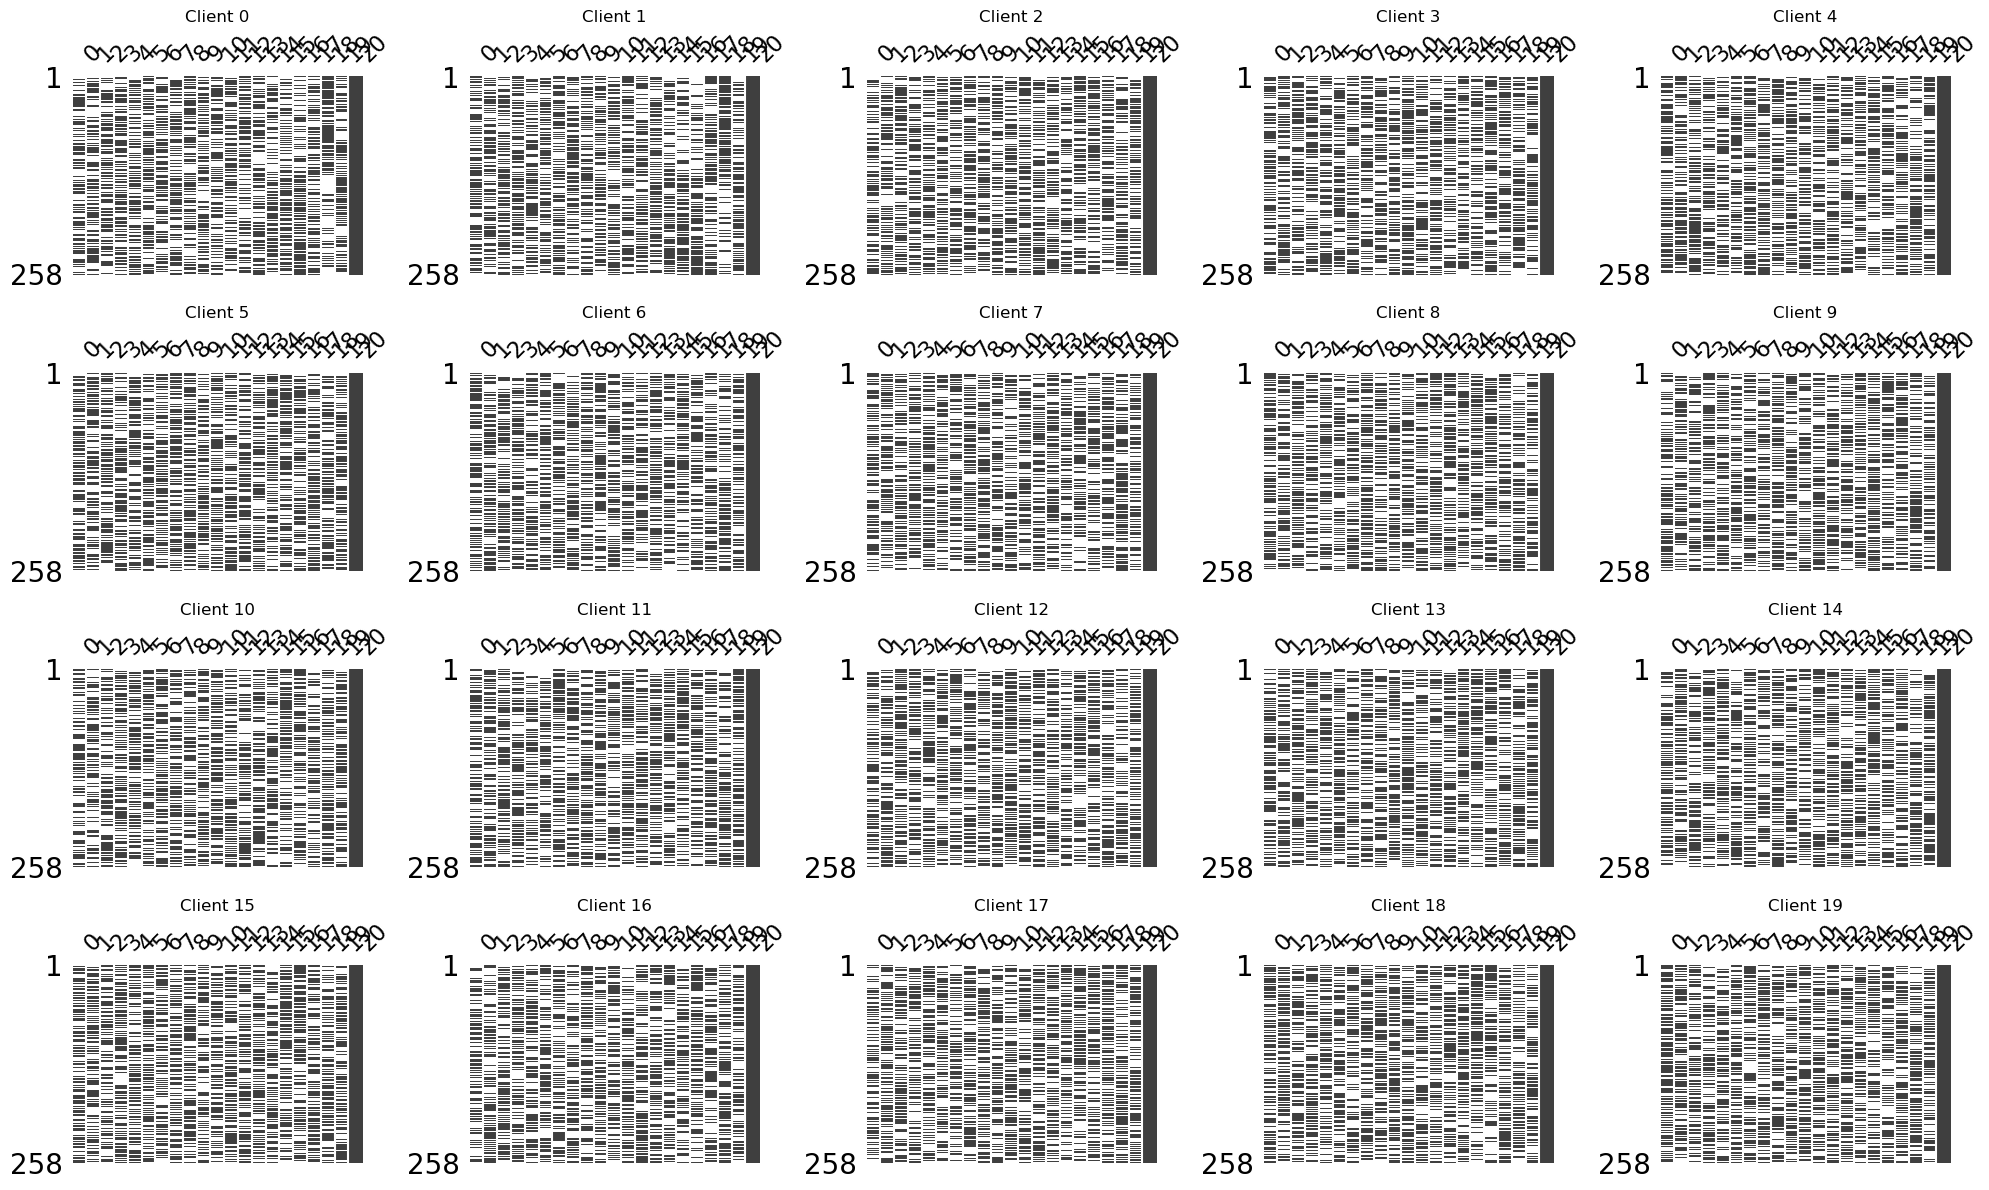

In [67]:
visualize_ms(data_ms_clients2)

### Federated Imputation

In [68]:
configuration['agg_strategy_imp']['strategy'] = 'fedavg-s'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = True
configuration['save_state'] = True
configuration['track'] = True

In [69]:
# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret2 = server.run()

2023-07-19 06:50:46.797 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:154 - Round: 50, test_accu: 0.7552, test_f1: 0.7549, val_loss: 0.6039, val_accu: 0.6577, val_f1: 0.6574
2023-07-19 06:51:16.107 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:154 - Round: 100, test_accu: 0.7833, test_f1: 0.7833, val_loss: 0.5750, val_accu: 0.6692, val_f1: 0.6690
2023-07-19 06:51:45.155 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:154 - Round: 150, test_accu: 0.7884, test_f1: 0.7884, val_loss: 0.5683, val_accu: 0.6750, val_f1: 0.6750
2023-07-19 06:52:14.725 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:154 - Round: 200, test_accu: 0.7924, test_f1: 0.7924, val_loss: 0.5671, val_accu: 0.6846, val_f1: 0.6844
2023-07-19 06:52:14.726 | INFO     | src.fed_imp.sub_modules.server.base_server:run:144 - model1 test acc: 0.794589 (0.000), test f1: 0.794571 (0.000)
2023-07-19 06:52:14.727 | INFO     | src.fed_imp.sub_modul

(5160, 21)
(5160, 21)
(11051, 21)
{'imp@rmse': 0.23292311428475426, 'imp@ws': 0.9816084177987733, 'imp@sliced_ws': 0.07459860491007793}


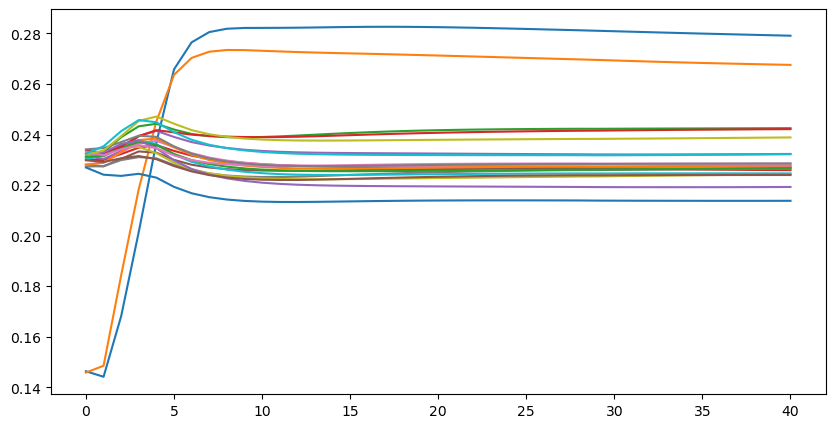

In [70]:
original_data2 = ret2['data']['origin_data'].reshape(-1, ret2['data']['origin_data'].shape[-1])
print(original_data2.shape)
centralized_data2 = ret2['data']['imputed_data'].reshape(-1, ret2['data']['imputed_data'].shape[-1])
print(centralized_data2.shape)
test_data2 = ret2['data']['test_data']
print(test_data2.shape)
print(ret2['imp_result'])

x = list(range(len(ret2['client_imp_history'])))
client_ids = list(ret2['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret2['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

### Centralized Evaluation

In [48]:
sklearn_evaluation(ret2)

Accuracy imputed centralized MLP:0.7960 (0.011)
Accuracy imputed centralized LR:0.8130 (0.000)
Accuracy orignal centralized MLP:0.9335 (0.003)
Accuracy orignal centralized MLP:0.8711 (0.000)


In [170]:
clients = {}
data_imp2 = ret2['data']['imputed_data']
missing_mask2 = ret2['data']['missing_mask']
data_true2 = ret2['data']['origin_data']
n_clients = ret2['data']['origin_data'].shape[0]
for client_id in range(n_clients):
    clients[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp2[client_id],
        missing_mask=missing_mask2[client_id],
        data_true=data_true2[client_id],
        data_test=test_data2
    )

pred_config = server_config_tmpl.copy()
server_name = 'central_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_pred_config['train_params']['pred_round'] = 1000
server_config = pred_config['server_config']
server = load_server(
        server_name, clients=clients, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data2
    )

pred_ret2 = server.prediction()

2023-07-18 21:26:44.894 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5104, train_loss: 0.6928 val_accu: 0.5837 val_f1: 0.5588
2023-07-18 21:26:46.122 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 10, test_accu: 0.5425, train_loss: 0.6640 val_accu: 0.6067 val_f1: 0.6061
2023-07-18 21:26:47.282 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 20, test_accu: 0.6699, train_loss: 0.6288 val_accu: 0.6615 val_f1: 0.6592
2023-07-18 21:26:48.407 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 30, test_accu: 0.7387, train_loss: 0.5919 val_accu: 0.7144 val_f1: 0.7140
2023-07-18 21:26:49.580 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 40, test_accu: 0.7312, train_loss: 0.5909 val_accu: 0.7038 val_f1: 0.7011
2023-07-18 21:26:50.764 | INFO 

In [171]:
pred_ret2

{'accu_mean': 0.7963080264229482,
 'f1_mean': 0.7960566237458183,
 'accu_std': 0.0,
 'f1_std': 0.0}

### Federated Evaluation Our Implementation

In [51]:
clients = {}
data_imp2 = ret2['data']['imputed_data']
missing_mask2 = ret2['data']['missing_mask']
data_true2 = ret2['data']['origin_data']
n_clients = ret2['data']['origin_data'].shape[0]
for client_id in range(n_clients):
    clients[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp2[client_id],
        missing_mask=missing_mask2[client_id],
        data_true=data_true2[client_id],
        data_test=test_data2
    )

pred_config = server_config_tmpl.copy()
server_name = 'fedavg_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_pred_config['train_params']['pred_round'] = 1000
server_config = pred_config['server_config']
server = load_server(
        server_name, clients=clients, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data2
    )

pred_ret2 = server.prediction()

2023-07-19 00:27:39.009 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.8110, test_f1: 0.8110, val_loss: 0.6289, val_accu: 0.6644, val_f1: 0.6624
2023-07-19 00:28:17.942 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.8120, test_f1: 0.8119, val_loss: 0.5960, val_accu: 0.7029, val_f1: 0.7012
2023-07-19 00:28:55.919 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.8074, test_f1: 0.8072, val_loss: 0.5873, val_accu: 0.7048, val_f1: 0.7034
2023-07-19 00:29:34.098 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.8102, test_f1: 0.8101, val_loss: 0.5831, val_accu: 0.7058, val_f1: 0.7037
2023-07-19 00:30:12.325 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.8108, test_f1: 0.810

## MNAR - Use complementary Models

In [71]:
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 20
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme'
config2['data_partition']['strategy'] = 'sample@p=0.01'
config2['agg_strategy_imp']['strategy'] = 'fedavg-s'

configuration = config2
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients2 = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients2, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)

sample {'p': '0.01'}
['mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right']


In [72]:
configuration['agg_strategy_imp']['strategy'] = 'testavg'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret4 = server.run()

testavg


2023-07-19 06:58:03.541 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 217.75325810001232


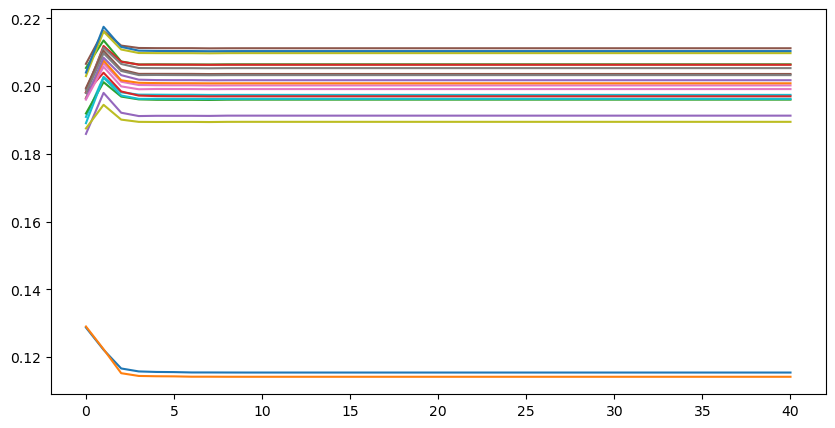

(5160, 21)
(5160, 21)
(11051, 21)


{'imp@rmse': 0.19274722233988992,
 'imp@ws': 0.8220280054776242,
 'imp@sliced_ws': 0.056273131325006255}

In [73]:
x = list(range(len(ret4['client_imp_history'])))
client_ids = list(ret4['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret4['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

original_data4 = ret4['data']['origin_data'].reshape(-1, ret4['data']['origin_data'].shape[-1])
print(original_data4.shape)
centralized_data4 = ret4['data']['imputed_data'].reshape(-1, ret4['data']['imputed_data'].shape[-1])
print(centralized_data4.shape)
test_data4 = ret4['data']['test_data']
print(test_data4.shape)
ret4['imp_result']

In [57]:
sklearn_evaluation(ret4)

Accuracy imputed centralized MLP:0.8534 (0.019)
Accuracy imputed centralized LR:0.8466 (0.000)
Accuracy orignal centralized MLP:0.9335 (0.003)
Accuracy orignal centralized MLP:0.8711 (0.000)


In [58]:
clients = {}
data_imp2 = ret4['data']['imputed_data']
missing_mask2 = ret4['data']['missing_mask']
data_true2 = ret4['data']['origin_data']
n_clients = ret4['data']['origin_data'].shape[0]
for client_id in range(n_clients):
    clients[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp2[client_id],
        missing_mask=missing_mask2[client_id],
        data_true=data_true2[client_id],
        data_test=test_data4
    )

pred_config = server_config_tmpl.copy()
server_name = 'fedavg_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_pred_config['train_params']['pred_round'] = 1000
server_config = pred_config['server_config']
server = load_server(
        server_name, clients=clients, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data4
    )

pred_ret2 = server.prediction()

2023-07-19 00:42:28.225 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.8082, test_f1: 0.8076, val_loss: 0.5718, val_accu: 0.7221, val_f1: 0.7216
2023-07-19 00:43:05.969 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.8303, test_f1: 0.8303, val_loss: 0.5296, val_accu: 0.7260, val_f1: 0.7254
2023-07-19 00:43:44.057 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.8376, test_f1: 0.8375, val_loss: 0.5216, val_accu: 0.7346, val_f1: 0.7345
2023-07-19 00:44:21.037 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.8451, test_f1: 0.8450, val_loss: 0.5191, val_accu: 0.7365, val_f1: 0.7365
2023-07-19 00:44:57.669 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.8477, test_f1: 0.847